In [49]:
# magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import numpy as np
from pathlib import Path, __file__
import pandas as pd
import pickle
import gillespy2 as gp
import matplotlib.pyplot as plt
import json
import os
from time import time

from importlib import import_module

from stochnet_v2.dataset.dataset import DataTransformer, HDF5Dataset
from stochnet_v2.static_classes.model import StochNet
from stochnet_v2.static_classes.trainer import ToleranceDropLearningStrategy, Trainer
from stochnet_v2.utils.file_organisation import ProjectFileExplorer
from stochnet_v2.utils.util import plot_random_traces, merge_species_and_param_settings
# from stochnet_v2.utils.util import generate_gillespy_traces

from simulation_gillespy import build_simulation_dataset
from util import generate_gillespy_traces

In [79]:
model_name = 'SIR'
timestep = 0.1
endtime = 8.0
dataset_id = 1
model_id = 1
nb_features = 3
# params_to_randomize = ['a11', 'a12', 'a21', 'b1']
params_to_randomize = ['beta', 'gamma']

In [80]:
project_folder = Path('').parent.resolve()/model_name
project_explorer = ProjectFileExplorer(project_folder)
dataset_explorer = project_explorer.get_dataset_file_explorer(timestep, dataset_id)
model_explorer = project_explorer.get_model_file_explorer(timestep, model_id)

body_config_path = model_explorer.body_config_fp
mixture_config_path = model_explorer.mixture_config_fp

In [81]:
CRN_module = import_module("stochnet_v2.CRN_models." + model_name)
CRN_class = getattr(CRN_module, model_name)

In [82]:
# generate traces (the big old problem)

nb_settings = 50
nb_trajectories = 50

nb_histogram_settings = 50
nb_histogram_trajectories = 50


settings = CRN_class.get_initial_settings(nb_settings)
print(f"settings shape: {settings.shape}")
print(f"Saving settings to {dataset_explorer.settings_fp}")
np.save(dataset_explorer.settings_fp, settings)

settings shape: (50, 3)
Saving settings to /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/SIR/dataset/data/0.1/1/settings.npy


In [83]:
dataset = build_simulation_dataset(
    model_name,                              # X16
    nb_settings,                             # 15
    nb_trajectories,                         # 10
    timestep,                                # 20
    endtime,                                 # 200
    dataset_explorer.dataset_folder,         # X16\dataset\data\20.0\2\
    params_to_randomize=params_to_randomize, # ['a11', 'a12', 'a21', 'b1']
    how='concat'
)

print(f"Saving dataset to {dataset_explorer.dataset_fp}")
np.save(dataset_explorer.dataset_fp, dataset)

dataset.simulation - INFO -  ===== CPU Cores used for simulations: 5 =====
dataset.simulation - INFO - Saving to partial_dataset_filepath: /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/SIR/dataset/data/0.1/1/partial_6.npy
dataset.simulation - INFO - Saved.
dataset.simulation - INFO - Saving to partial_dataset_filepath: /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/SIR/dataset/data/0.1/1/partial_9.npy
dataset.simulation - INFO - Saved.
dataset.simulation - INFO - Saving to partial_dataset_filepath: /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/SIR/dataset/data/0.1/1/partial_0.npy
dataset.simulation - INFO - Saved.
dataset.simulation - INFO - Saving to partial_dataset_filepath: /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/SIR/dataset/data/0.1/1/partial_3.npy
dataset.simulation - INFO - Saved.
dataset.simulation - INFO - Saving to partial_dataset_filepath: /home/ivan/Documents/ms-project/masters-project/S

100%|██████████| 50/50 [00:00<00:00, 491.99it/s]

dataset.simulation - INFO - >>>> done...
Saving dataset to /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/SIR/dataset/data/0.1/1/dataset.npy


In [84]:
dataset.shape

(2500, 81, 6)

In [85]:
histogram_settings = CRN_class.get_initial_settings(nb_histogram_settings)
print(f"histogram_settings shape: {histogram_settings.shape}")
print(f"Saving histogram_settings to {dataset_explorer.histogram_settings_fp}")
np.save(dataset_explorer.histogram_settings_fp, histogram_settings)

histogram_dataset = build_simulation_dataset(
    model_name,
    nb_histogram_settings,
    nb_histogram_trajectories,
    timestep,
    endtime,
    dataset_explorer.dataset_folder,
    params_to_randomize=params_to_randomize,
    prefix='histogram_partial_',
    how='stack',
    settings_filename=os.path.basename(dataset_explorer.histogram_settings_fp),
)
print(f"Saving histogram_dataset to {dataset_explorer.histogram_dataset_fp}")
np.save(dataset_explorer.histogram_dataset_fp, histogram_dataset)

histogram_settings shape: (50, 3)
Saving histogram_settings to /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/SIR/dataset/data/0.1/1/histogram_settings.npy
dataset.simulation - INFO -  ===== CPU Cores used for simulations: 5 =====
dataset.simulation - INFO - Saving to partial_dataset_filepath: /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/SIR/dataset/data/0.1/1/histogram_partial_0.npy
dataset.simulation - INFO - Saved.
dataset.simulation - INFO - Saving to partial_dataset_filepath: /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/SIR/dataset/data/0.1/1/histogram_partial_9.npy
dataset.simulation - INFO - Saved.
dataset.simulation - INFO - Saving to partial_dataset_filepath: /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/SIR/dataset/data/0.1/1/histogram_partial_3.npy
dataset.simulation - INFO - Saved.
dataset.simulation - INFO - Saving to partial_dataset_filepath: /home/ivan/Documents/ms-project/masters-projec

100%|██████████| 50/50 [00:00<00:00, 570.20it/s]

dataset.simulation - INFO - >>>> done...
Saving histogram_dataset to /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/SIR/dataset/data/0.1/1/histogram_dataset.npy


In [86]:
histogram_dataset.shape

(50, 50, 81, 6)

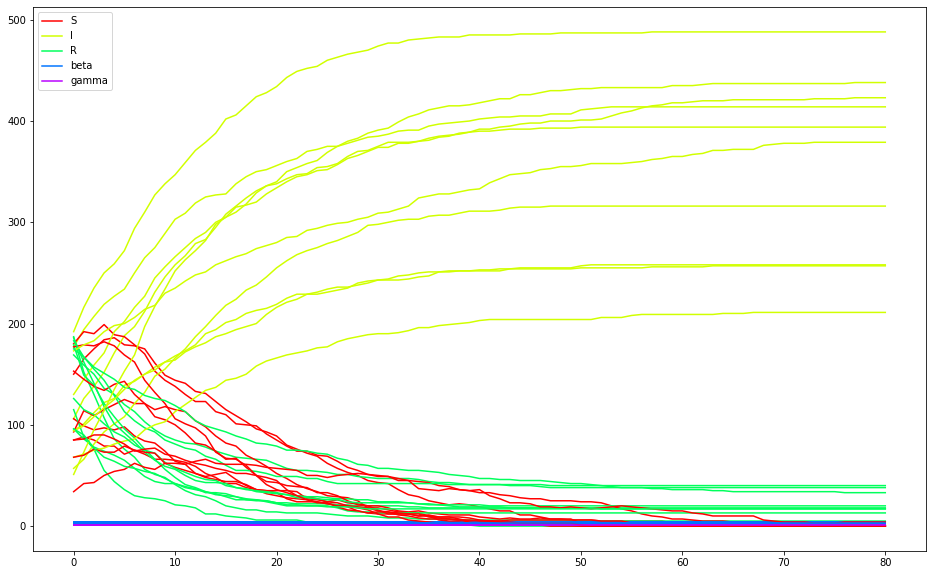

In [87]:
n = 10

plt.figure(figsize=(16, 10))
plot_random_traces(dataset, 1, labels=CRN_class.get_species_names() + params_to_randomize)
plt.legend()
plot_random_traces(dataset, n - 1, labels=CRN_class.get_species_names() + params_to_randomize)

In [88]:
dt = DataTransformer(
    dataset_explorer.dataset_fp,
    with_timestamps=True,
    nb_randomized_params=len(params_to_randomize)
)

In [89]:
np.random.seed(11)

dt.save_data_for_ml_hdf5(
    dataset_folder=dataset_explorer.dataset_folder,
    nb_past_timesteps=1,
    test_fraction=0.2,
    keep_timestamps=False,
    rescale=True,
    positivity=False,
    shuffle=True,
    slice_size=100,
    force_rewrite=True
)

dataset.dataset - INFO - Fitting scaler, positivity=False


100%|██████████| 25/25 [00:00<00:00, 506.77it/s]

dataset.dataset - INFO - Train data saved to /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/SIR/dataset/data/0.1/1/train_rescaled.hdf5, 
Shapes: x: (160000, 1, 5), y: (160000, 3)
dataset.dataset - INFO - Test data saved to /home/ivan/Documents/ms-project/masters-project/StochNetV2/project/SIR/dataset/data/0.1/1/test_rescaled.hdf5, 
Shapes: x: (40000, 1, 5), y: (40000, 3)


In [90]:
import h5py

data_file = h5py.File(dataset_explorer.train_rescaled_fp, 'r')

x_data = data_file['x']
y_data = data_file['y']

i = 200

dt.scale_back(x_data[i]), dt.scale_back(y_data[i])

(array([[ 70.00000075, 181.00000285, 165.00000408,   2.42826248,
           0.76266009]]),
 array([ 66.99999906, 189.00000083, 160.00000064]))

In [91]:
ds = HDF5Dataset(dataset_explorer.train_rescaled_fp, 64)

c = 0

for x, y in ds:
    print(f'{x.shape}, {y.shape}')
    c += 1
    if c > 10:
        break
    else:
        continue
    break

(64, 1, 5), (64, 3)
(64, 1, 5), (64, 3)
(64, 1, 5), (64, 3)
(64, 1, 5), (64, 3)
(64, 1, 5), (64, 3)
(64, 1, 5), (64, 3)
(64, 1, 5), (64, 3)
(64, 1, 5), (64, 3)
(64, 1, 5), (64, 3)
(64, 1, 5), (64, 3)
(64, 1, 5), (64, 3)


In [92]:
# configure the model

body_hidden_size = 30
body_n_blocks = 2
body_activation = "relu"
body_regularizer = "none"
body_kernel_constraint = "none"
body_bias_constraint = "none"
body_kernel_regularizer = "l2"
body_bias_regularizer = "l2"


components_hidden_size = "none"
n_normal_diag = 6
n_normal_tril = 0
n_log_normal_tril = 0
components_activation = "none"
components_regularizer = "none"
components_kernel_constraint = "none"
components_bias_constraint = "none"
components_kernel_regularizer = "l2"
components_bias_regularizer = "l2"


body_config = {
    "body_fn_name": "body_b",
    "block_name": "a",
    "hidden_size": body_hidden_size,
    "n_blocks": body_n_blocks,
    "use_batch_norm": False,
    "activation": body_activation,
    "activity_regularizer": body_regularizer,
    "kernel_constraint": body_kernel_constraint,
    "kernel_regularizer": body_kernel_regularizer,
    "bias_constraint": body_bias_constraint,
    "bias_regularizer": body_bias_regularizer
}

categorical_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "coeff_regularizer": "none",
    "kernel_constraint": components_kernel_constraint,  # "maxnorm"
    "kernel_regularizer": components_kernel_regularizer,
    "bias_constraint": components_bias_constraint,  # "maxnorm"
    "bias_regularizer": components_bias_regularizer
}

normal_diag_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": "l2",
    "kernel_constraint": components_kernel_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_constraint": components_bias_constraint,
    "bias_regularizer": components_bias_regularizer
}

normal_tril_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": components_regularizer,
    "sub_diag_regularizer": components_regularizer,
    "kernel_constraint": components_kernel_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_constraint": components_bias_constraint,
    "bias_regularizer": components_bias_regularizer
}

log_normal_tril_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": components_regularizer,
    "sub_diag_regularizer": components_regularizer,
    "kernel_constraint": components_kernel_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_constraint": components_bias_constraint,
    "bias_regularizer": components_bias_regularizer
}

In [93]:
# write config files

mixture_config = \
[["categorical", categorical_config]] + \
[["normal_diag", normal_diag_config] for i in range(n_normal_diag)] + \
[["normal_tril", normal_tril_config] for i in range(n_normal_tril)] + \
[["log_normal_tril", log_normal_tril_config] for i in range(n_log_normal_tril)]

with open(body_config_path, 'w+') as f:
    json.dump(body_config, f, indent='\t')

with open(mixture_config_path, 'w+') as f:
    json.dump(mixture_config, f, indent='\t')

In [100]:
# configure the training strategy

learning_strategy = ToleranceDropLearningStrategy(
    optimizer_type='adam',
    initial_lr=1e-4,
    lr_decay=0.3,
    epochs_tolerance=7,
    minimal_lr=1e-7,
)

n_epochs = 250
batch_size = 256
add_noise = True
stddev = 0.01
dataset_kind = 'hdf5'

In [101]:
nn = StochNet(
    nb_past_timesteps=1,
    nb_features=nb_features,
    nb_randomized_params=len(params_to_randomize),
    project_folder=project_folder,
    timestep=timestep,
    dataset_id=dataset_id,
    model_id=model_id,
)

static_classes.nn_bodies - INFO - 
 ** Building 'body_b' body, hidden size: 30 
    with 2 of 'a' block 
    activation: relu 
    activity_regularizer: none 
    kernel_constraint: none 
    kernel_regularizer: l2 
    bias_constraint: none 
    bias_regularizer: l2 
    use BatchNorm: False 
 ** 

static_classes.top_layers - DEBUG - Mixture components share nn outputs
static_classes.top_layers - DEBUG - base shape: [None, 30]
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.model - INFO - Model's graph keys saved at /home/

In [102]:
ckpt_path = None

ckpt_path = Trainer().train(
    nn,
    n_epochs=n_epochs,
    batch_size=batch_size,
    learning_strategy=learning_strategy,
    ckpt_path=ckpt_path,
    dataset_kind=dataset_kind,
    add_noise=add_noise,
    stddev=stddev,
)

ckpt_path

static_classes.trainer - DEBUG - REGULARIZATION_LOSSES:Tensor("total_regularization_loss:0", shape=(), dtype=float32)
static_classes.trainer - INFO - Total number of trainable vars 36
static_classes.trainer - INFO - Total number of optimizer vars 74
static_classes.trainer - INFO - Training...
static_classes.trainer - INFO - 
Epoch: 1
static_classes.trainer - INFO -  = Minimal loss value = 1.3841562271118164,
 - 625 steps took 27.5 seconds, avg_step_time=0.044
 - test time: 0.8 seconds
static_classes.trainer - INFO - 
Epoch: 2
static_classes.trainer - INFO -  = Minimal loss value = -1.4794673919677734,
 - 625 steps took 16.1 seconds, avg_step_time=0.026
 - test time: 0.2 seconds
static_classes.trainer - INFO - 
Epoch: 3
static_classes.trainer - INFO -  = Minimal loss value = -2.7979211807250977,
 - 625 steps took 11.3 seconds, avg_step_time=0.018
 - test time: 0.3 seconds
static_classes.trainer - INFO - 
Epoch: 4
static_classes.trainer - INFO -  = Minimal loss value = -3.721329689025879

'/home/ivan/Documents/ms-project/masters-project/StochNetV2/project/SIR/models/0.1/1/checkpoints/best_ckpt_79849'

In [103]:
from stochnet_v2.utils.evaluation import evaluate
from stochnet_v2.utils.util import plot_random_traces

distance_kind = 'dist'
target_species_names = ['S', 'I']
time_lag_range = [1, 3, 5, 10, 15, 20]
settings_idxs_to_save_histograms = [i for i in range(10)]

In [104]:
histogram_explorer = dataset_explorer.get_histogram_file_explorer(model_id, 0)
nn_histogram_data_fp = os.path.join(histogram_explorer.model_histogram_folder, 'nn_histogram_data.npy')

evaluate(
    model_name=model_name,
    project_folder=project_folder,
    timestep=timestep,
    dataset_id=dataset_id,
    model_id=model_id,
    nb_randomized_params=len(params_to_randomize),
    nb_past_timesteps=1,
    n_bins=100,
    distance_kind=distance_kind,
    with_timestamps=True,
    save_histograms=True,
    time_lag_range=time_lag_range,
    target_species_names=target_species_names,
    path_to_save_nn_traces=nn_histogram_data_fp,
    settings_idxs_to_save_histograms=settings_idxs_to_save_histograms,
)

static_classes.model - INFO - Model created in inference mode.
utils.evaluation - INFO - Start generating NN traces


100%|██████████| 80/80 [00:02<00:00, 31.52it/s]

utils.evaluation - INFO - Done. generated data shape: (50, 50, 81, 4)
utils.evaluation - INFO - Took 2.7 seconds


utils.evaluation - INFO - Start calculating distances for different time-lags, using 7 CPU cores for multiprocessing
utils.evaluation - INFO - Took 1.4 seconds
utils.evaluation - INFO - Start building histograms for different settings: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
and time-lags: [1, 3, 5, 10, 15, 20]


100%|██████████| 6/6 [00:16<00:00,  2.69s/it]

utils.evaluation - INFO - Took 16.1 seconds
utils.evaluation - INFO - All done.


In [105]:
nn = StochNet(
    nb_past_timesteps=1,
    nb_features=nb_features,
    nb_randomized_params=len(params_to_randomize),
    project_folder=project_folder,
    timestep=timestep,
    dataset_id=dataset_id,
    model_id=model_id,
    mode='inference'
)

static_classes.model - INFO - Model created in inference mode.


In [106]:
n_settings = 15
traj_per_setting = 50
n_steps = 40

m = CRN_class(endtime, timestep)

initial_settings = m.get_initial_settings(n_settings)
randomized_params = m.get_randomized_parameters(params_to_randomize, n_settings)

settings = merge_species_and_param_settings(initial_settings, randomized_params)
settings

array([[ 72.        ,  73.        , 169.        ,   3.7108041 ,
          0.71406142],
       [159.        ,  84.        ,  86.        ,   3.53385377,
          1.35462441],
       [ 45.        ,  89.        ,  99.        ,   2.87285232,
          1.25606106],
       [155.        ,  68.        , 150.        ,   3.00456006,
          1.24086397],
       [ 37.        , 188.        ,  30.        ,   3.73190312,
          0.71113832],
       [171.        , 100.        , 131.        ,   3.27540721,
          0.74284845],
       [ 65.        , 197.        , 192.        ,   3.59556061,
          0.91652627],
       [ 41.        ,  74.        , 100.        ,   2.25611433,
          1.29853205],
       [133.        ,  80.        , 156.        ,   1.87256387,
          0.98380606],
       [ 84.        , 179.        ,  47.        ,   3.00701614,
          0.6382972 ],
       [ 41.        ,  62.        , 186.        ,   2.28101763,
          0.68456404],
       [ 95.        ,  54.        , 150.   

In [107]:
setting_idx = 0

curr_state = settings[setting_idx:setting_idx+1, np.newaxis, :]
curr_state

array([[[ 72.        ,  73.        , 169.        ,   3.7108041 ,
           0.71406142]]])

In [108]:
next_state_samples = nn.next_state(
    curr_state_values=curr_state,
    curr_state_rescaled=False,
    scale_back_result=True,
    round_result=False,
    n_samples=10000,
)

# [n_samples, n_settings, 1, n_features]
next_state_samples.shape

(10000, 1, 1, 3)

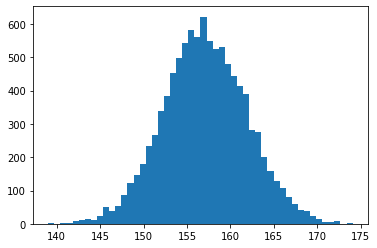

In [109]:
species_idx = 2

samples = np.squeeze(next_state_samples, -2)[..., species_idx]

_ = plt.hist(samples, bins=50)

In [110]:
start = time()

gillespy_traces = generate_gillespy_traces(
    settings=settings,
    n_steps=n_steps,
    timestep=timestep,
    gillespy_model=m,
    params_to_randomize=params_to_randomize,
    traj_per_setting=traj_per_setting,
)

gillespy_time = time() - start

gillespy_traces.shape, gillespy_time

root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.





root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.
root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.
root - WARNING - show_labels = False is deprecated. Future releases of GillesPy2 may not support this feature.
r

((15, 50, 40, 4), 12.24815821647644)

In [111]:
start = time()

nn_traces = nn.generate_traces(
    settings[:, np.newaxis, :],
    n_steps=n_steps,
    n_traces=traj_per_setting,
    curr_state_rescaled=False,
    scale_back_result=True,
    round_result=True,
    add_timestamps=True,
)

nn_time = time() - start

nn_traces.shape, nn_time

100%|██████████| 40/40 [00:00<00:00, 146.40it/s]


((15, 50, 41, 4), 0.2814209461212158)

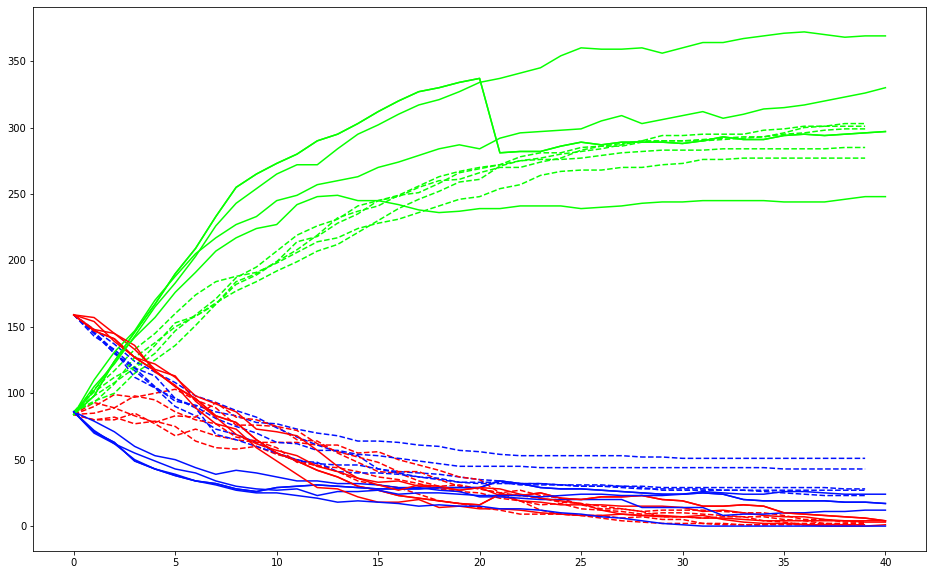

In [112]:
k = 1
n_traces = 5

plt.figure(figsize=(16, 10))
plot_random_traces(gillespy_traces[k][...,:nb_features+1], n_traces, linestyle='--', marker='')
plot_random_traces(nn_traces[k], n_traces, linestyle='-', marker='')

In [ ]:
# simulation with timestep 1.0 and endtime 5.0 (5 steps)
# 2 trajectories for each of the 5 settings
# target dimensions are (25, 5, 5)

sim = [[np.random.rand(5, 5) for j in range(2)] for i in range(5)]

In [ ]:
single_sim = sim[0]
single_sim[0].shape

In [ ]:
stacked_sims_vstack = np.vstack([np.stack(single_sim) for single_sim in sim])
print(stacked_sims_vstack.shape)
print(stacked_sims_vstack)

In [ ]:
a1 = np.array([[1, 2, 3], ['a', 'b', 'c']])
a2 = np.array([[3, 4, 5], ['d', 'e', 'f']])
a3 = np.array([[6, 7, 8], ['g', 'h', 'i']])

In [ ]:
a4 = np.stack([a1, a2, a3])
a4.shape